In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import plot, plot_missing, plot_correlation, create_report

import pretty_midi
import os
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             roc_auc_score, ConfusionMatrixDisplay, f1_score,
                             accuracy_score, classification_report)

In [2]:
import tensorflow as tf
tf.__version__

'2.12.0'

We will do very minor exploration below.

In [38]:
midi_file = "bach342.mid"
midi_file = pretty_midi.PrettyMIDI(midi_file)

In [39]:
midi_file.instruments

[Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1"),
 Instrument(program=6, is_drum=False, name="Track 1")]

In [40]:
midi_file2 = "handel107.mid"
midi_file2 = pretty_midi.PrettyMIDI(midi_file2)

In [41]:
midi_file2.instruments

[Instrument(program=70, is_drum=False, name="Joshua"),
 Instrument(program=40, is_drum=False, name="Strings I"),
 Instrument(program=48, is_drum=False, name="Strings II"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Double Bass"),
 Instrument(program=6, is_drum=False, name="Harpsichord Treble"),
 Instrument(program=6, is_drum=False, name="Harpsichord Bass")]

In [42]:
midi_file3 = "handel147.mid"
midi_file3 = pretty_midi.PrettyMIDI(midi_file3)

C:\Users\yousi\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [43]:
midi_file3.instruments

[Instrument(program=68, is_drum=False, name="Oboe I"),
 Instrument(program=68, is_drum=False, name="Oboe II"),
 Instrument(program=70, is_drum=False, name="Bassoon"),
 Instrument(program=48, is_drum=False, name="Violin I"),
 Instrument(program=48, is_drum=False, name="Violin II"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Double Bass"),
 Instrument(program=6, is_drum=False, name="Harpsichord RH"),
 Instrument(program=6, is_drum=False, name="Harpsichord LH")]

From the quick explorations above in 3 separate songs, we notice that the names of the instruments vary widely between them. Thus, we will not be using this information in the model, but we will use use the notes from those instruents without allowing for the ability to tell which instrument is which. This is obviously not a great way to proceed since each instrument is played differently even within the same composer but it seems like the better option for now.  

**Note:** after further research, we found out that the program attribute is standardized. It's an integer between 0 and 127 inclusive. We can include this information for future work and we think that it will be a great indicator feature to add to classify composers.

Below is a sample of the notes that we're going to extract.

In [138]:
midi_file.instruments[0].notes[:50]

[Note(start=0.449219, end=0.597656, pitch=49, velocity=127),
 Note(start=1.821615, end=1.970052, pitch=61, velocity=127),
 Note(start=2.295573, end=2.444010, pitch=61, velocity=127),
 Note(start=3.667969, end=3.816406, pitch=73, velocity=127),
 Note(start=4.576823, end=4.710938, pitch=73, velocity=127),
 Note(start=7.343750, end=9.472656, pitch=73, velocity=127),
 Note(start=14.266927, end=14.358073, pitch=73, velocity=127),
 Note(start=14.430990, end=15.522135, pitch=73, velocity=127),
 Note(start=15.653646, end=15.714844, pitch=73, velocity=127),
 Note(start=16.283854, end=16.535156, pitch=73, velocity=127),
 Note(start=15.778646, end=16.673177, pitch=61, velocity=127),
 Note(start=16.789062, end=17.040365, pitch=73, velocity=127),
 Note(start=17.799479, end=18.050781, pitch=61, velocity=127),
 Note(start=18.304688, end=18.555990, pitch=61, velocity=127),
 Note(start=19.062500, end=19.313802, pitch=73, velocity=127),
 Note(start=19.567708, end=19.819010, pitch=73, velocity=127),
 Not

In [19]:
def extract_features(midi_file: str, max_num_of_points: int, stride: int):
    """
    This function will extract features from the midi files and extracts their features
        Parameters:
            midi_file: a string that has the file path to the midi file
            max_num_of_points: the maximum number of notes and durations to extract from each song
            stride: the index jump value used in returning the notes, i.e., every stride'th note and duration
        returns:
            ([notes], [durations]): a list with notes and their respective duration
    """
    
    
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    notes = [0] * max_num_of_points
    durations = [0] * max_num_of_points
    # this doesn't take into account the instrument name. We took this approach because
    # different composers have different instrument name and it's not unified
    # thus, it will introduce a level of complexity and it might not be all that beneficial
    # if we have too many different instruments which is what we've observed from a quick check
    
    i = 0
    max_reached = False
    
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            if i == max_num_of_points:
                max_reached = True
                break
            notes[i] = note.pitch
            durations[i] = note.end - note.start
            i += 1
        if max_reached:
            break
        
    # If the number of notes exceed max_num_of_points, the rest will be truncated.
    # If we have less than max_num_of_points points, we resort to padding with zeros in the end.
    
    return notes[::stride], durations[::stride] 

In [30]:
def build_dataset(dataset_directory: str, max_num_of_points: int, stride: int):
    composers = [] # this will hold the composers' names

    features_list = []
    labels_list = [] # composer name corresponding to features in features_list

    for composer in os.listdir(dataset_directory):
        if composer.startswith("."): # to avoid processing ".DS_Store"
            continue

        composers.append(composer)
        composer_directory = os.path.join(dataset_directory, composer)
        for midi_file in os.listdir(composer_directory):
            if midi_file.startswith(".") or not midi_file.endswith(".mid"): # to avoid processing ".DS_Store"
                continue

            file_path = os.path.join(composer_directory, midi_file)

            notes, durations = extract_features(file_path, max_num_of_points, stride)
            features_list.append(np.column_stack((notes, durations)))
            labels_list.append(composer)
    
    return np.array(features_list), labels_list, composers

The code above takes a while to run, thus we will persist the data using **joblib**.

In [116]:
dataset_directory ="data/train"
max_num_of_points = 4000
stride = 5

features_list, labels_list, composers = build_dataset(
    dataset_directory, max_num_of_points, stride
)


joblib.dump(features_list, "features_list.joblib")
joblib.dump(labels_list, "labels_list.joblib")
joblib.dump(composers, "composers.joblib")

C:\Users\yousi\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


['composers.joblib']

In [4]:
features_list = joblib.load("features_list.joblib")
labels_list = joblib.load("labels_list.joblib")
composers = joblib.load("composers.joblib")

Now we will rescale our data using MinMaxScaler

In [5]:
sc = MinMaxScaler()

features_list = sc.fit_transform(features_list.reshape(
                 features_list.shape[0] *
                 features_list.shape[1],
                 features_list.shape[-1]
)).reshape(features_list.shape)

Now we will build our data sequences to prepare them for the LSTM

In [6]:
X_train = []
y_train = []

seq_length = 20 # window of 20 consecutive notes

for song_index in range(len(labels_list)):
    for note_index in range(len(features_list[song_index]) - seq_length):
        curr_seq = features_list[song_index, note_index:note_index+seq_length, :]
        if np.isin([0], curr_seq)[0]: # if we reach the zero padding in the end, we will
                                      # skip the song as we no longer have any notes left
            break
        X_train.append(curr_seq)
        y_train.append(labels_list[song_index])

We will encode the composers using one-hot-encoding

In [8]:
composer_encoder = OneHotEncoder(categories=[composers], sparse_output=False)

y_train = composer_encoder.fit_transform(np.array(y_train).reshape(-1,1))
y_train = tf.constant(y_train, dtype=tf.float32)

In [25]:
# Build the LSTM model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=150, input_shape=(seq_length, X_train.shape[-1]),
                        return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(composers), activation="softmax")
])

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

# Train the model
num_epochs = 300
batch_size = 32 # default batch size
model_path = "model.h5"

history = model2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max'),
                       tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)]
          )

Epoch 1/300
4918/4918 - 174s - loss: 1.8740 - accuracy: 0.2980 - val_loss: 3.1328 - val_accuracy: 0.0000e+00 - 174s/epoch - 35ms/step
Epoch 2/300
4918/4918 - 165s - loss: 1.7812 - accuracy: 0.3387 - val_loss: 3.2751 - val_accuracy: 0.0000e+00 - 165s/epoch - 33ms/step
Epoch 3/300
4918/4918 - 176s - loss: 1.6862 - accuracy: 0.3751 - val_loss: 3.2444 - val_accuracy: 0.0000e+00 - 176s/epoch - 36ms/step
Epoch 4/300
4918/4918 - 166s - loss: 1.5132 - accuracy: 0.4313 - val_loss: 3.2223 - val_accuracy: 0.0000e+00 - 166s/epoch - 34ms/step
Epoch 5/300
4918/4918 - 169s - loss: 1.4504 - accuracy: 0.4551 - val_loss: 3.0420 - val_accuracy: 1.2073e-04 - 169s/epoch - 34ms/step
Epoch 6/300
4918/4918 - 167s - loss: 1.3862 - accuracy: 0.4801 - val_loss: 3.3533 - val_accuracy: 0.0012 - 167s/epoch - 34ms/step
Epoch 7/300
4918/4918 - 169s - loss: 1.3240 - accuracy: 0.5044 - val_loss: 3.4972 - val_accuracy: 6.0365e-04 - 169s/epoch - 34ms/step
Epoch 8/300
4918/4918 - 177s - loss: 1.2613 - accuracy: 0.5280 - v

We can see that the validation accuracy we achieved was a measly 19% approximately even though the training accuracy is about 92%. This tells us that the sequence that we have built for the training data is not informative enough of the composer. We can make the case that the model isn't performing well because it's not complex enough but I don't believe that this is the case. I've experimented with different architectures and layers but it didn't help in any significant way. I don't think hyperparameter tuning will give us a very big boost in the accuracy, either.  

Now, we will rebuild the data sets and take consecutive notes rather than with a stride of 5 (every 5th note). We'll see if this imrpoves the performance. We will also increase the window size for the sequences from 20 to 40 to see if this helps increase the accuracy of the validation set.

In [12]:
# Build the LSTM model
model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=150, input_shape=(seq_length, X_train.shape[-1]),
                        return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(composers), activation="softmax")
])

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

# Train the model
num_epochs = 300
batch_size = 32 # default batch size
model_path = "model2.h5"

history = model2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max'),
                       tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)]
          )

Epoch 1/300
4918/4918 - 208s - loss: 1.8337 - accuracy: 0.3140 - val_loss: 3.1390 - val_accuracy: 0.0000e+00 - 208s/epoch - 42ms/step
Epoch 2/300
4918/4918 - 205s - loss: 1.5445 - accuracy: 0.4234 - val_loss: 3.0820 - val_accuracy: 0.0000e+00 - 205s/epoch - 42ms/step
Epoch 3/300
4918/4918 - 199s - loss: 1.4396 - accuracy: 0.4626 - val_loss: 3.2794 - val_accuracy: 0.0000e+00 - 199s/epoch - 41ms/step
Epoch 4/300
4918/4918 - 201s - loss: 1.3663 - accuracy: 0.4902 - val_loss: 3.1983 - val_accuracy: 2.4146e-04 - 201s/epoch - 41ms/step
Epoch 5/300
4918/4918 - 203s - loss: 1.3091 - accuracy: 0.5110 - val_loss: 3.3322 - val_accuracy: 0.0041 - 203s/epoch - 41ms/step
Epoch 6/300
4918/4918 - 201s - loss: 1.2481 - accuracy: 0.5356 - val_loss: 3.1706 - val_accuracy: 0.0264 - 201s/epoch - 41ms/step
Epoch 7/300
4918/4918 - 199s - loss: 1.1850 - accuracy: 0.5602 - val_loss: 3.0658 - val_accuracy: 0.0652 - 199s/epoch - 40ms/step
Epoch 8/300
4918/4918 - 207s - loss: 1.1142 - accuracy: 0.5874 - val_loss:

We notice that we get very similar results which tells us that the complexity we introduced isn't really catching much more of the underlying patterns. We will now change the way we extract the information from the midi files. We will not use a stride (greater than 1) as opposed to extracting every 5th note as we did before.  

We will also increase our sequence length when building the data for the model. We will use a length of 50 notes. Hopefully, the increase of the window will make it easier for the model to classify the composer accurately.

In [21]:
dataset_directory ="data/train"
max_num_of_points = 800
stride = 1

features_list, labels_list, _ = build_dataset(
    dataset_directory, max_num_of_points, stride
)

features_list = np.array(features_list)

C:\Users\yousi\anaconda3\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [24]:
sc = MinMaxScaler()

features_list = sc.fit_transform(features_list.reshape(
                 features_list.shape[0] *
                 features_list.shape[1],
                 features_list.shape[-1]
)).reshape(features_list.shape)

In [25]:
X_train = []
y_train = []

seq_length = 50 # window of 50 consecutive notes

for song_index in range(len(labels_list)):
    for note_index in range(len(features_list[song_index]) - seq_length):
        curr_seq = features_list[song_index, note_index:note_index+seq_length, :]
        if np.isin([0], curr_seq)[0]: # if we reach the zero padding in the end, we will
                                      # skip the song as we no longer have any notes left
            break
        X_train.append(curr_seq)
        y_train.append(labels_list[song_index])
        
X_train = tf.constant(np.array(X_train), dtype=tf.float32)
y_train = composer_encoder.transform(np.array(y_train).reshape(-1,1))
y_train = tf.constant(y_train, dtype=tf.float32)

In [27]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=150, input_shape=(seq_length, X_train.shape[-1]),
                        return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(composers), activation="softmax")
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

# Train the model
num_epochs = 300
batch_size = 32 # default batch size
model_path = "model.h5"

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='max'),
                       tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)]
          )

Epoch 1/300
7486/7486 - 704s - loss: 1.8244 - accuracy: 0.3362 - val_loss: 3.0907 - val_accuracy: 0.0000e+00 - 704s/epoch - 94ms/step
Epoch 2/300
7486/7486 - 634s - loss: 1.7032 - accuracy: 0.3845 - val_loss: 3.0977 - val_accuracy: 2.3794e-04 - 634s/epoch - 85ms/step
Epoch 3/300
7486/7486 - 644s - loss: 1.5024 - accuracy: 0.4586 - val_loss: 2.9599 - val_accuracy: 7.1383e-04 - 644s/epoch - 86ms/step
Epoch 4/300
7486/7486 - 634s - loss: 1.2057 - accuracy: 0.5621 - val_loss: 2.7481 - val_accuracy: 0.0798 - 634s/epoch - 85ms/step
Epoch 5/300
7486/7486 - 647s - loss: 0.9479 - accuracy: 0.6573 - val_loss: 2.5599 - val_accuracy: 0.1622 - 647s/epoch - 86ms/step
Epoch 6/300
7486/7486 - 630s - loss: 0.7435 - accuracy: 0.7321 - val_loss: 3.6125 - val_accuracy: 0.0911 - 630s/epoch - 84ms/step
Epoch 7/300
7486/7486 - 630s - loss: 0.5828 - accuracy: 0.7912 - val_loss: 3.5736 - val_accuracy: 0.1620 - 630s/epoch - 84ms/step
Epoch 8/300
7486/7486 - 773s - loss: 0.4600 - accuracy: 0.8359 - val_loss: 4.1

We achieved a slightly better resut here. It's not great by any means and if we used more of the data- here we only extracted the first 800 notes and their durations- we can possibly receive better accuracy.  

Now, let's build our test set and evaluate the model performance on it.

In [31]:
dataset_directory ="data/test"
max_num_of_points = 800
stride = 1

features_list_test, labels_list_test, _ = build_dataset(
    dataset_directory, max_num_of_points, stride
)


features_list_test = sc.transform(features_list_test.reshape(
                 features_list_test.shape[0] *
                 features_list_test.shape[1],
                 features_list_test.shape[-1]
)).reshape(features_list_test.shape)



In [32]:
X_test = []
y_test = []

seq_length = 50 # window of 50 consecutive notes

for song_index in range(len(labels_list_test)):
    for note_index in range(len(features_list_test[song_index]) - seq_length):
        curr_seq = features_list_test[song_index, note_index:note_index+seq_length, :]
        if np.isin([0], curr_seq)[0]: # if we reach the zero padding in the end, we will
                                      # skip the song as we no longer have any notes left
            break
        X_test.append(curr_seq)
        y_test.append(labels_list_test[song_index])
        
X_test = tf.constant(np.array(X_test), dtype=tf.float32)
y_test = composer_encoder.transform(np.array(y_test).reshape(-1,1))
y_test = tf.constant(y_test, dtype=tf.float32)

In [35]:
model.evaluate(X_test, y_test)

750/750 [==============================] - 22s 28ms/step - loss: 3.6692 - accuracy: 0.4875


[3.669236421585083, 0.4875046908855438]

We see that we've gotten 50% accuracy approximately

In [110]:
predictions = model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)

750/750 [==============================] - 23s 30ms/step


accuracy: 0.48750469356251824
precision: 0.4866015460881798
recall: 0.4807512965662387
f1-score: 0.4711233571751809
auc score: 0.8160568337581541


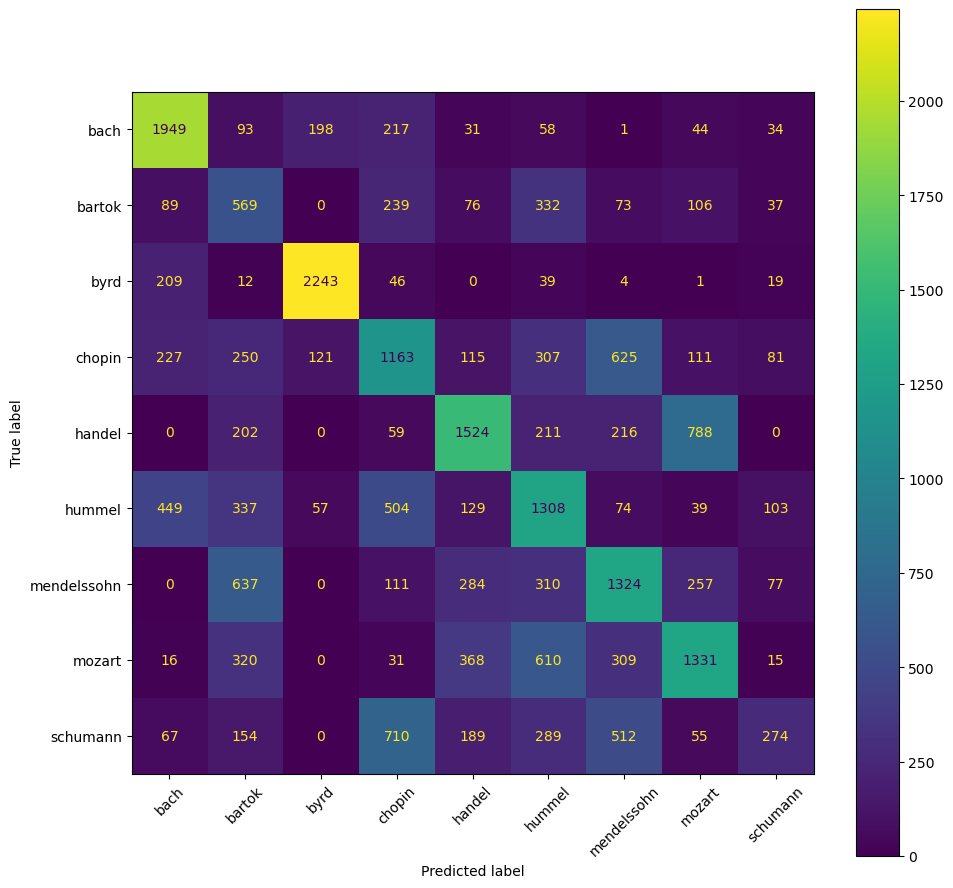

In [115]:
y_test_classes = np.argmax(y_test, axis=1)

print("accuracy:", accuracy_score(y_test_classes, class_predictions))
print("precision:", precision_score(y_test_classes, class_predictions, average="macro")) # macro for each label
print("recall:", recall_score(y_test_classes, class_predictions, average="macro"))
print("f1-score:", f1_score(y_test_classes, class_predictions, average="macro"))
print("auc score:", roc_auc_score(y_test_classes, predictions, average="macro", multi_class="ovo")) # "ovo" = one-vs-one

fig, ax = plt.subplots(figsize=(11, 11))
cm = confusion_matrix(np.argmax(y_test, axis=1), class_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm,
                      display_labels=composer_encoder.categories[0]).plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [125]:
report = classification_report(y_test_classes, class_predictions, target_names=composer_encoder.categories[0])
print(report)

              precision    recall  f1-score   support

        bach       0.65      0.74      0.69      2625
      bartok       0.22      0.37      0.28      1521
        byrd       0.86      0.87      0.86      2573
      chopin       0.38      0.39      0.38      3000
      handel       0.56      0.51      0.53      3000
      hummel       0.38      0.44      0.40      3000
 mendelssohn       0.42      0.44      0.43      3000
      mozart       0.49      0.44      0.46      3000
    schumann       0.43      0.12      0.19      2250

    accuracy                           0.49     23969
   macro avg       0.49      0.48      0.47     23969
weighted avg       0.50      0.49      0.48     23969



We can see that we did somewhat reasonably. Keep in mind that we're only taking a window of 50 notes. If we wanted to do better, we would extend that window further. Also, we would train with a lot more data than just the first 800. We limited these numbers because of our computational restraints. As it is now, it took us about 3 hours to train. This made it harder to experiment. We notice that the best performing classes or composers are `Bach` and `Byrd`.  

One more feature we could have added and would probably make the predictions get better is the velocity of each note. It would certainly make training the model take longer but we are confident that it can contribute in a noticeable way to our model's performance.  

Another feature is the instrument number. As we mentioned in our **note** above, we found out that the instrument number is a standardized attribute and would have been easily added to the features that we extract. For time considerations, since the model will take so long to retrain. We leave this and the velocity features to be added in future work. We hypothesize that they can contribute very significantly to the performance.